In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from sklearn.model_selection import train_test_split
import seaborn as sns

In [12]:
#load 
url='https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df=pd.read_csv(url,usecols=['Passengers'])
df.head()

,Passengers
0,112
1,118
2,132
3,129
4,121


In [32]:
#Data Preprocessing :Normalize the dataset for better performance of the neural network
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

#create 
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)
#prepare
time_step = 10
X, Y = create_dataset(scaled_data, time_step)

#SPLIT
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#reshape 
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [22]:
#Build and train thr RNN Model
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), verbose=1)


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.1251 - val_loss: 0.0881
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1027 - val_loss: 0.0120
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0316 - val_loss: 0.0215
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0236 - val_loss: 0.0248
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0291 - val_loss: 0.0079
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0118 - val_loss: 0.0129
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0168 - val_loss: 0.0059
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0096 - val_loss: 0.0079
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0089 - val_loss: 0.0054
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0083 - val_loss: 0.0062
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0064 - val_loss: 0.0048
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0068 - val_l

In [8]:
!pip install seaborn


In [34]:
#Predict and Evaluation
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

#Inverse transform to get the actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
#Y_train = scaler.inverse_transform([Y_train])
#Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(Y_train, train_predict[:,0]))
test_rmse = np.sqrt(mean_squared_error(Y_test, test_predict[:,0]))

print(f'Train RMSE: {train_rmse}')
print(f'Train RMSE: {test_rmse}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Train RMSE: 21.52355107828995
Train RMSE: 20.813798677468384


In [42]:
#Compare with a Traditional Time Series Model (ARIMA)
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
model_arima = ARIMA(df, order=(5,1,0))
model_arima_fit = model_arima.fit()

#Forecast
arima_pred = model_arima_fit.forecast(steps=len(X_test))

#Calculate RMSE for ARIMA
arima_rmse = np.sqrt(mean_squared_error(df[-len(arima_pred):], arima_pred))
print(f'ARIMA RMSE: {arima_rmse}')

ARIMA RMSE: 96.63626284391589


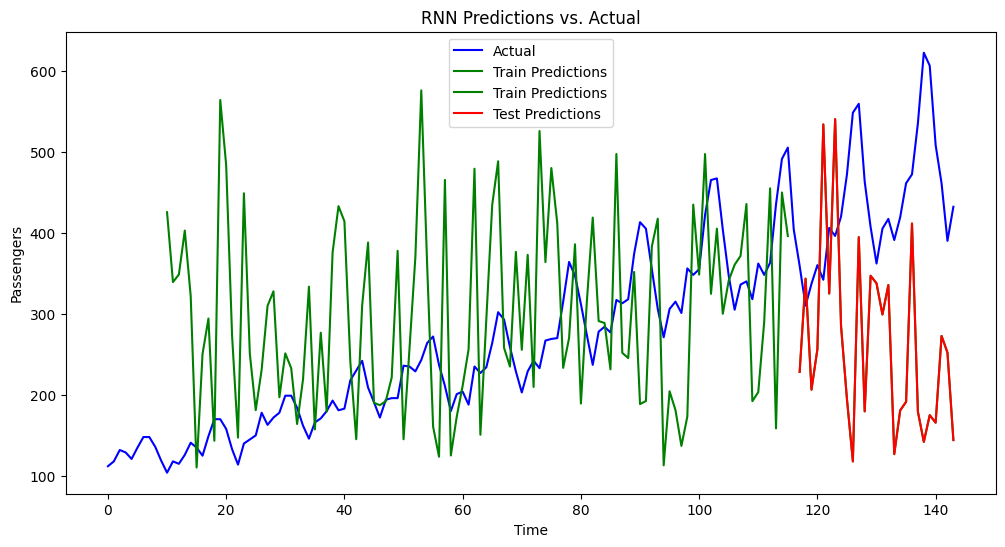

Gayatri Kulkarni - 53004230002


In [46]:
#Visualization : RNN Predications vs. Actual Vlues
plt.figure(figsize=(12,6))

#plot the actual data
plt.plot(df, label='Actual', color='blue')

#Plot the training predictions
plt.plot(range(time_step, time_step + len(train_predict)), train_predict, color='green', label='Train Predictions')

#Plot the testing predictions
plt.plot(range(len(df) - len(test_predict), len(df)), test_predict, color='green', label='Train Predictions')

#Plot the testing predictions
plt.plot(range(len(df) - len(test_predict), len(df)), test_predict, color='red', label='Test Predictions')

plt.legend()
plt.title('RNN Predictions vs. Actual')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.show()

print("Gayatri Kulkarni - 53004230002")